# Sentiment analysis with Convolutional Neural Networks

The following model aims to predict wether an amazon review is positive or negative. The product reviews are from the Home and Kitchen section.

First the required packages are imported.

In [ ]:
import pandas as pd 
import numpy as np
import keras as ks
from matplotlib import pyplot
import gzip 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

Next the data is loaded.

In [350]:
def parse(path): 
    g = gzip.open(path, 'rb') 
    for l in g: 
        yield eval(l) 
def getDF(path): 
    i = 0 
    df = {} 
    for d in parse(path): 
        df[i] = d 
        i += 1 
    return pd.DataFrame.from_dict(df, orient='index')
df = getDF('reviews_Home_and_Kitchen_5.json.gz')

We check the structure.

In [353]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


The target variable will be based on the overall rating column, therefore, samples with that missing variable are excluded.

In [ ]:
df = df[df['overall'].notnull()]

We are going to label as positive review those with rating above 3 and as negative those below 3.

In [356]:
df = df[df['overall']!=3.0]
df.loc[df['overall']>3.0, 'sent'] = 1
df.loc[df['overall']<3.0, 'sent'] = 0

Summary and reviewText are concatenated such that there is only one input for the model.

In [357]:
df['review'] = df['summary'] + '. ' + df['reviewText']

We check again the dataset.

In [358]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sent,review
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013",1.0,Best Price. My daughter wanted this book and t...
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014",1.0,zoku. I bought this zoku quick pop for my daug...
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013",1.0,"Excels at Sweet Dessert Pops, but Falls Short ..."
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011",1.0,Creative Combos. This book is a must have if y...
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014",1.0,A must own if you own the Zoku maker.... This ...


In [359]:
df['review'].iloc[0]

'Best Price. My daughter wanted this book and the price on Amazon was the best.  She has already tried one recipe a day after receiving the book.  She seems happy with it.'

All the variables that are not of interest are dropped.

In [360]:
df = df[['review','sent']]

Next we split into train and test dataset at 80/20.

In [361]:
train, test = train_test_split(df, test_size=0.2)

Check what is the balance between postive and negative classes.

In [362]:
train.sent.value_counts()

1.0    364192
0.0     41106
Name: sent, dtype: int64

We can see that this is and unbalanced dataset. As the computing resources are limited and the amount of data large enough, we are going to randomly drop a number of postive cases until the dataset is balanced. That will help with common class inbalance issues and help with the undestanding of accuracy measures.

In [363]:
# Class count
count_class_0 = (train['sent'] == 0).sum()
count_class_1 = (train['sent'] == 1).sum()

# Divide by class
df_class_0 = train[train['sent'] == 0]
df_class_1 = train[train['sent'] == 1]
df_class_1_under = df_class_1.sample(count_class_0)
train = pd.concat([df_class_1_under, df_class_0], axis=0)
print('Random under-sampling:')
print(train.sent.value_counts())

Random under-sampling:
0.0    41106
1.0    41106
Name: sent, dtype: int64


Lets check now the number of unique words in the resulting dataset.

In [364]:
print(len(np.unique(np.hstack(train.review))))

82211


### Text preprocessing

In [387]:
import re, string, unicodedata
import nltk
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

First we expand the contractions.

In [389]:
train['review'] = train['review'].apply(contractions.fix)
test['review'] = test['review'].apply(contractions.fix)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Lets check it.

In [390]:
train['review'].iloc[0]

'can NOT recommend. these dish cloths worked great for me at first but after several washings they are falling apart.  i am having the same problems with the towels.  do not waste your money.'

Looks good. Now we will tokenize the text

In [393]:
train['review'] = train['review'].apply(nltk.word_tokenize)
test['review'] = test['review'].apply(nltk.word_tokenize)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [394]:
train['review'].iloc[0]

['can',
 'NOT',
 'recommend',
 '.',
 'these',
 'dish',
 'cloths',
 'worked',
 'great',
 'for',
 'me',
 'at',
 'first',
 'but',
 'after',
 'several',
 'washings',
 'they',
 'are',
 'falling',
 'apart',
 '.',
 'i',
 'am',
 'having',
 'the',
 'same',
 'problems',
 'with',
 'the',
 'towels',
 '.',
 'do',
 'not',
 'waste',
 'your',
 'money',
 '.']

Next we are going to do a set of transformations.

In [397]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

train['review'] = train['review'].apply(normalize)
test['review'] = test['review'].apply(normalize)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Lets check the number of unique words.

In [398]:
len(train['review'].apply(pd.Series).stack().unique())

93566

And the number of words in each sample.

In [401]:
train['totalwords'] = train['review'].str.len().copy()
print("Mean %.2f words STD(%f)" % (np.mean(train['totalwords']), np.std(train['totalwords'])))

Mean 46.44 words STD(32.682022)


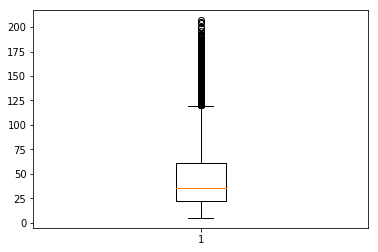

In [402]:
pyplot.boxplot(train['totalwords'])
pyplot.show()

We will drop the 10% most extreme samples in terms of number of words such that we have a better look at the number of words in each.

In [403]:
train = train[train['totalwords']>train['totalwords'].quantile(0.05)]
train = train[train['totalwords']<train['totalwords'].quantile(0.95)]

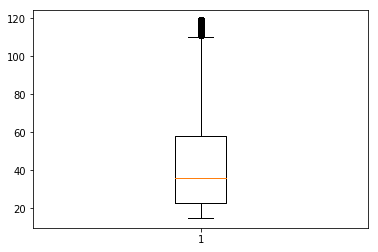

In [404]:
pyplot.boxplot(train['totalwords'])
pyplot.show()

Lets check if the dataset is still balanced.

In [405]:
print(train.sent.value_counts())

0.0    33473
1.0    32465
Name: sent, dtype: int64


Looks good! Lets finally resent the indexes.

In [406]:
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,review,sent,totalwords
0,"[quiet, effective, aesthetic, new, air, purifi...",1.0,54
1,"[really, sleek, excellent, item, really, enjoy...",1.0,22
2,"[knockoff, made, china, real, kitchenaid, buy,...",0.0,52
3,"[second, gelpro, mat, long, days, kitchen, hol...",1.0,38
4,"[design, needs, improvement, item, holds, lid,...",0.0,65


We are going to detokenize now such that we can take advantage of Keras tokenizer later.

In [412]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

train['review'] = train['review'].apply(TreebankWordDetokenizer().detokenize)
test['review'] = test['review'].apply(TreebankWordDetokenizer().detokenize)

We will tokenize now with Keras tokenizer and use the top 500 most common words for word sequences.

In [413]:
# Create sequence
vocabulary_size = 500
t = Tokenizer(num_words= vocabulary_size)
t.fit_on_texts(train['review'])

Pad dataset to a maximum review length in words.

In [419]:
max_words = 100
sequences_train = t.texts_to_sequences(train['review'])
X_train = ks.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_words)
sequences_test = t.texts_to_sequences(test['review'])
X_test = ks.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_words)
print(X_train)

[[  0   0   0 ... 346 268  90]
 [  0   0   0 ...  23   4   8]
 [  0   0   0 ... 302 487 107]
 ...
 [  0   0   0 ...  97  39 105]
 [  0   0   0 ... 236 302 432]
 [  0   0   0 ...   5  46 237]]


### Modelling

In [420]:
# Import dependencies
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers.embeddings import Embedding

In [ ]:
Compile the LSTM neural network.

In [424]:
embedding_vector_length = 32 
model = Sequential() 
model.add(Embedding(top_words, 
                    embedding_vector_length, 
                    input_length=max_words)) 
model.add(Dropout(0.25))
model.add(LSTM(units=50,
               activation='tanh',
               recurrent_activation='hard_sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary()) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 100, 32)           16000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 32,651
Trainable params: 32,651
Non-trainable params: 0
_________________________________________________________________
None


We have 32651 parameters to optimize.

In [425]:
# Fit the model
model.fit(X_train, 
          train.sent, 
          validation_data=(X_test, test.sent), 
          epochs=3, 
          batch_size=128,
          verbose=1)

Train on 65938 samples, validate on 101325 samples
Epoch 1/3
65938/65938 [==============================] - 237s 4ms/step - loss: 0.3825 - acc: 0.8289 - val_loss: 0.2427 - val_acc: 0.9050
Epoch 2/3
65938/65938 [==============================] - 231s 4ms/step - loss: 0.3153 - acc: 0.8642 - val_loss: 0.3246 - val_acc: 0.8554
Epoch 3/3
65938/65938 [==============================] - 236s 4ms/step - loss: 0.3035 - acc: 0.8692 - val_loss: 0.3181 - val_acc: 0.8678


The models is trained and we have achieved a 87% accuracy in the validation dataset within a few minutes of training!

Data source citation:
Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016